In [1]:
%%capture
!git clone https://github.com/egusg/comp432.git
%cd benchmarks
!git submodule update --init --recursive
%cd /content/comp432/benchmarks/MOABB
!pip install -r speechrequirements.txt
!pip install -e .
!pip install -r ../../requirements.txt    # Install base dependencies
!pip install -r extra-requirements.txt    # Install additional dependencies
%cd /content/comp432/benchmarks/MOABB
%env PYTHON_PATH=/content/benchmarks/

%cd /content/comp432/benchmarks/MOABB/

In [2]:
!pip install --upgrade mne mne-bids

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: mne-bids
    Found existing installation: mne-bids 0.13
    Uninstalling mne-bids-0.13:
      Successfully uninstalled mne-bids-0.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moabb 1.0.0 requires mne-bids<0.14,>=0.13, but you have mne-bids 0.14 which is incompatible.


In [3]:
!./run_experiments.sh --hparams /content/example_hyperparams.yaml \
--data_folder '/content/data/BNCI2014001'\
--cached_data_folder '/content/data' \
--output_folder '/content/results/full-experiment/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 1 --train_mode 'leave-one-session-out' \
--number_of_epochs 2 \
--device 'cuda'

hparams: /content/example_hyperparams.yaml
data_folder: /content/data/BNCI2014001
cached_data_folder: /content/data
output_folder: /content/results/full-experiment/BNCI2014001
nsbj: 9
nsess: 2
seed: 20031
nruns: 1
eval_metric: acc
eval_set: test
train_mode: leave-one-session-out
rnd_dir: False
additional flags: --number_of_epochs 2 --device cuda 
Subject 0
2024-04-26 00:10:14.362602: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 00:10:14.414828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 00:10:14.414871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting 

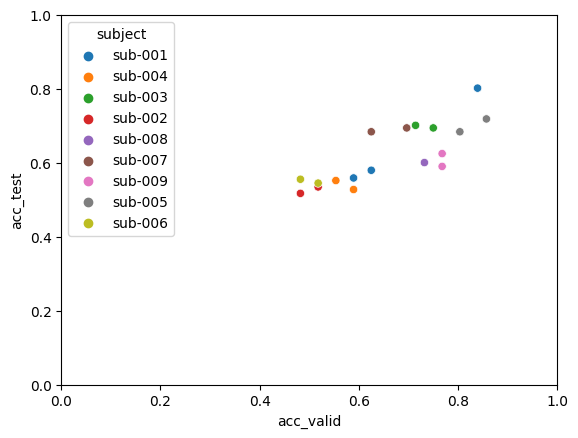

In [ ]:
# %% [code]
import pathlib as pl
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = []
for path in pl.Path('/content/results').glob('**/*_metrics.pkl'):
    with open(path, 'rb') as f:
        metrics = pkl.load(f)
    parts = path.parts
    set_ = parts[-1].split('_')[0]
    session = parts[-2]
    subject = parts[-3]
    trial = parts[-7]
    seed = parts[-5]
    run = parts[-6]
    metrics.update(session=session, subject=subject, trial=trial, seed=seed, run=run, set=set_)
    data.append(metrics)

# Create DataFrame
data = pd.DataFrame(data)
data = data.set_index(['trial', 'session', 'subject', 'set'])
valid = data.xs('valid', level='set')
test = data.xs('test', level='set')
data = valid.join(test, lsuffix='_valid', rsuffix='_test')

# Plot
sns.scatterplot(data=data, x='acc_valid', y='acc_test', hue='subject')
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.show()

**NEW MODEL **

In [ ]:
"""EEGNet from https://doi.org/10.1088/1741-2552/aace8c.
Shallow and lightweight convolutional neural network proposed for a general decoding of single-trial EEG signals.
It was proposed for P300, error-related negativity, motor execution, motor imagery decoding.

Authors
 * Davide Borra, 2021
"""
import torch
import speechbrain as sb


class EEGNet(torch.nn.Module):
    """EEGNet.

    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    cnn_septemporal_depth_multiplier: int
        Depth multiplier of the 2d temporal separable convolution.
    cnn_septemporal_kernelsize: tuple
        Kernel size of the 2d temporal separable convolution.
    cnn_septemporal_pool: tuple
        Pool size and stride after the 2d temporal separable convolution.
    cnn_pool_type: string
        Pooling type.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    activation_type: str
        Activation function of the hidden layers.

    Example
    -------
    #>>> inp_tensor = torch.rand([1, 200, 32, 1])
    #>>> model = EEGNet(input_shape=inp_tensor.shape)
    #>>> output = model(inp_tensor)
    #>>> output.shape
    #torch.Size([1,4])
    """

    def __init__(
        self,
        input_shape=None,  # (1, T, C, 1)
        cnn_temporal_kernels=8,
        cnn_temporal_kernelsize=(33, 1),
        cnn_spatial_depth_multiplier=2,
        cnn_spatial_max_norm=1.0,
        cnn_spatial_pool=(4, 1),
        cnn_septemporal_depth_multiplier=1,
        cnn_septemporal_point_kernels=None,
        cnn_septemporal_kernelsize=(17, 1),
        cnn_septemporal_pool=(8, 1),
        cnn_pool_type="avg",
        dropout=0.5,
        dense_max_norm=0.25,
        dense_n_neurons=4,
        activation_type="elu",
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if activation_type == "gelu":
            activation = torch.nn.GELU()
        elif activation_type == "elu":
            activation = torch.nn.ELU()
        elif activation_type == "relu":
            activation = torch.nn.ReLU()
        elif activation_type == "leaky_relu":
            activation = torch.nn.LeakyReLU()
        elif activation_type == "prelu":
            activation = torch.nn.PReLU()
        else:
            raise ValueError("Wrong hidden activation function")
        self.default_sf = 128  # sampling rate of the original publication (Hz)
        # T = input_shape[1]
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        # Temporal convolution
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        # Spatial depthwise convolution
        cnn_spatial_kernels = (
            cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                bias=False,
                max_norm=cnn_spatial_max_norm,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", activation)
        self.conv_module.add_module(
            "pool_1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))

        # New convolutional layer
        ##################### Added layer ##########################

        new_out_channels = 16  # Example number of filters
        new_kernel_size = (3, 1)  # Example kernel size
        self.conv_module.add_module(
            "conv_new",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_spatial_kernels,
                out_channels=new_out_channels,
                kernel_size=new_kernel_size,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_new",
            sb.nnet.normalization.BatchNorm2d(
                input_size=new_out_channels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_new", torch.nn.ReLU())  # Using ReLU for simplicity

        ##################### Added layer ##########################

        # Temporal separable convolution
        cnn_septemporal_kernels = (
            cnn_spatial_kernels * cnn_septemporal_depth_multiplier
        )
        self.conv_module.add_module(
            "conv_2",
            sb.nnet.CNN.Conv2d(
                in_channels=new_out_channels,
                out_channels=cnn_septemporal_kernels,
                kernel_size=cnn_septemporal_kernelsize,
                groups=new_out_channels,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        if cnn_septemporal_point_kernels is None:
            cnn_septemporal_point_kernels = cnn_septemporal_kernels

        self.conv_module.add_module(
            "conv_3",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_septemporal_kernels,
                out_channels=cnn_septemporal_point_kernels,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_septemporal_point_kernels,
                momentum=0.01,
                affine=True,
            ),
        )
        self.conv_module.add_module("act_3", activation)
        self.conv_module.add_module(
            "pool_3",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_septemporal_pool,
                stride=cnn_septemporal_pool,
                pool_axis=[1, 2],
            ),
        )
        self.conv_module.add_module("dropout_3", torch.nn.Dropout(p=dropout))

        # Shape of intermediate feature maps
        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)
        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.dense_module(x)
        return x



In [ ]:
# Save the yaml file on disk
f = open('/content/example_hyperparams.yaml', "w")
f.write(example_hyperparams)
f.close()

NameError: name 'example_hyperparams' is not defined